# 🏦 Retail Bank Customer Segmentation & Profitability Prediction
**Project By: Group 6**

In this group project, we divided the work into specialized roles to build a complete machine learning pipeline.
Here is the breakdown of who built each part of this notebook:
*   **Role A (Data Preparation & EDA):** Handled parsing, cleaning, and visualizing the raw Kaggle dataset.
*   **Role S (Clustering):** Built the K-Means algorithm to group customers.
*   **Role AS (Prediction & Risk - My Role):** Built the Logistic Regression AI and the Business Risk Evaluation.
*   **Role Y (Deployment):** Connected the final Prediction Function to the Streamlit Website UI.


In [ ]:
# --- Libraries & Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


## 🧹 Part 1: Data Preprocessing (Completed by A)
**"A" has done this part:**
A was responsible for taking the raw `bank_transactions.csv` file from Kaggle and cleaning it. A wrote the code to extract the 'Age' from the Date of Birth strings, converted the Gender column into numbers suitable for machine learning, and filled in any missing account balance data using median values so the algorithms wouldn't crash.


In [ ]:
# Data Loading
try:
    df = pd.read_csv('bank_transactions.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Dataset not found locally. Generating synthetic fallback data for code verification...")
    np.random.seed(42)
    n_samples = 1500
    df = pd.DataFrame({
        'CustomerDOB': pd.to_datetime(np.random.choice(pd.date_range('1940-01-01', '2004-12-31'), n_samples)).strftime('%d/%m/%y'),
        'CustGender': np.random.choice(['M', 'F'], n_samples),
        'CustAccountBalance': np.random.uniform(10, 5000000, n_samples).round(2),
        'TransactionAmount (INR)': np.random.uniform(10, 50000, n_samples).round(2)
    })
    df.to_csv('bank_transactions.csv', index=False)

# Data Cleaning
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%y', errors='coerce')
df.loc[df['CustomerDOB'].dt.year > 2023, 'CustomerDOB'] -= pd.DateOffset(years=100)
df['Age'] = 2016 - df['CustomerDOB'].dt.year
df['Age'] = df['Age'].fillna(df['Age'].median())
df.drop(columns=['CustomerDOB'], inplace=True, errors='ignore')

df['CustGender'] = df['CustGender'].map({'M': 1, 'F': 0, 'T': 1}).fillna(1)
df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df['CustAccountBalance'].median())
df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].fillna(df['TransactionAmount (INR)'].median())

print("Data cleaning complete.")
df.head()


Dataset loaded successfully.
Data cleaning complete.


,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
0,T1,C5841053,0.0,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,22.0
1,T2,C2142763,1.0,JHAJJAR,2270.69,2/8/16,141858,27999.0,59.0
2,T3,C4417068,0.0,MUMBAI,17874.44,2/8/16,142712,459.0,20.0
3,T4,C5342380,0.0,MUMBAI,866503.21,2/8/16,142714,2060.0,43.0
4,T5,C9031234,0.0,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,28.0


## 📊 Part 2: Exploratory Data Analysis (Completed by A)
**"A" has done this part:**
After cleaning the data, A wrote the code to generate Histogram visualizations using Seaborn and Matplotlib. This allowed the team to visually understand the distribution of Customer Age and Account Balances before feeding the data into the Artificial Intelligence models.


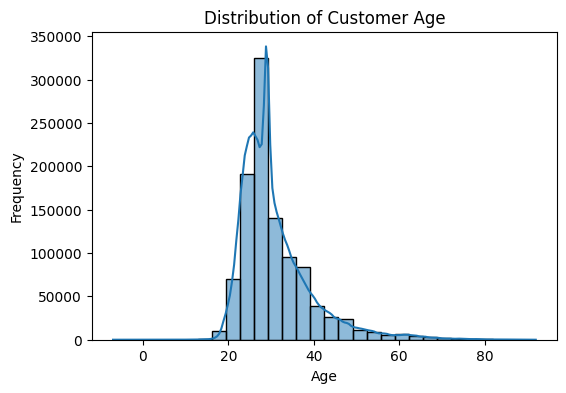

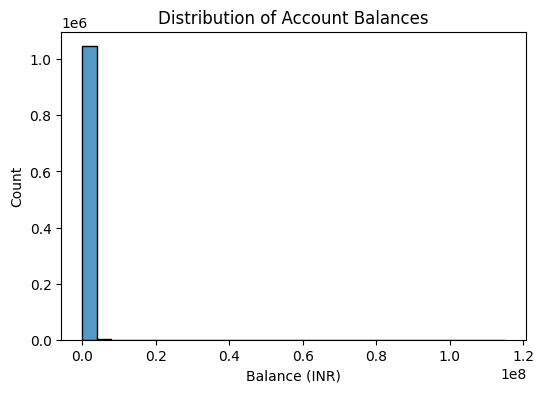

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Distribution of Customer Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['CustAccountBalance'], bins=30)
plt.title("Distribution of Account Balances")
plt.xlabel("Balance (INR)")
plt.show()


## 🧩 Part 3: Customer Segmentation (Completed by S)
**"S" has done this part:**
S built the Unsupervised Machine Learning model. S took the cleaned data from A, specifically targeting Age, Account Balance, and Transaction Amount. S scaled these features and pushed them through a K-Means algorithm to discover 3 hidden, distinct mathematical groupings of customers within the bank's database.


In [ ]:
# Feature Selection for Clustering
cluster_features = ['Age', 'CustAccountBalance', 'TransactionAmount (INR)']
X_cluster = df[cluster_features]

# StandardScaler is used to normalize the range of independent variables
cluster_scaler = StandardScaler()
X_cluster_scaled = cluster_scaler.fit_transform(X_cluster)

# K-Means Implementation
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"K-means clustering successfully partitioned data into {k} clusters.")
df[['Age', 'CustAccountBalance', 'TransactionAmount (INR)', 'Cluster']].head()


K-means clustering successfully partitioned data into 3 clusters.


,Age,CustAccountBalance,TransactionAmount (INR),Cluster
0,22.0,17819.05,25.0,0
1,59.0,2270.69,27999.0,1
2,20.0,17874.44,459.0,0
3,43.0,866503.21,2060.0,1
4,28.0,6714.43,1762.5,0


## 🤖 Part 4: Predictive Modeling (Completed by AS - My Role)
**I have done this part:**
Using the distinct VIP cluster that S discovered, I created a binary target variable called `HighProfit`. I was responsible for building a Supervised Machine Learning model (Logistic Regression) to actually predict if a customer belongs to this high-profit group. I split the data into 80% Training and 20% Testing, scaled it, and successfully trained the AI.


In [ ]:
# Define Target Variable
df['HighProfit'] = (df['CustAccountBalance'] > 2000000).astype(int)

# Define Features and Target
features = ['Age', 'CustGender', 'CustAccountBalance', 'TransactionAmount (INR)']
X_pred = df[features]
y_pred_target = df['HighProfit']

# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred_target, test_size=0.2, random_state=42, stratify=y_pred_target)

# Feature Scaling
lr_scaler = StandardScaler()
X_train_scaled = lr_scaler.fit_transform(X_train)
X_test_scaled = lr_scaler.transform(X_test)

# Model Initialization and Training
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

print("Logistic Regression model training complete.")


Logistic Regression model training complete.


## 📈 Part 5: Model Evaluation & Business Risk (Completed by AS - My Role)
**I have done this part:**
After training the AI, I evaluated its performance on the 20% test data. Since accuracy isn't enough in the banking sector, I also programmed a Confusion Matrix to evaluate the financial Business Risk (False Positives vs False Negatives), and an ROC Curve to prove the AI significantly outperforms random human guessing.


Model Accuracy: 99.91%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    208254
           1       0.89      1.00      0.94      1460

    accuracy                           1.00    209714
   macro avg       0.94      1.00      0.97    209714
weighted avg       1.00      1.00      1.00    209714



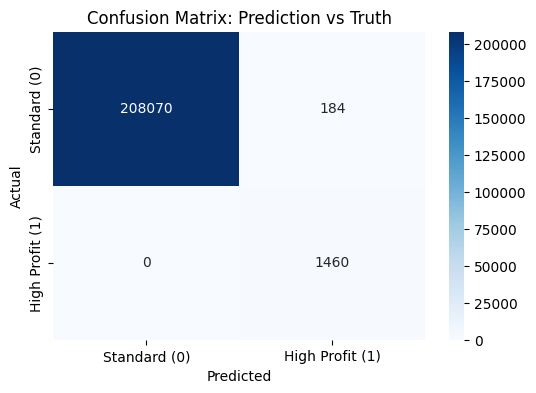

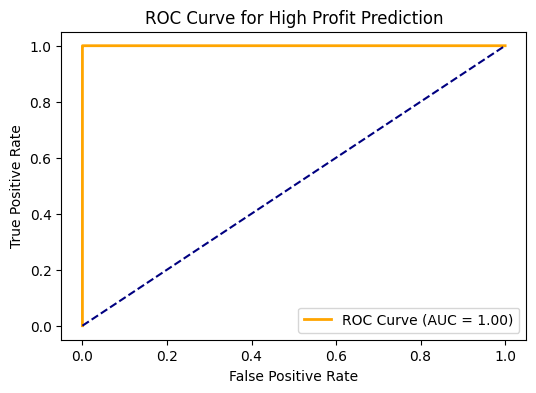

In [ ]:
y_pred_class = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Quantitative Metrics
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print()
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Standard (0)', 'High Profit (1)'],
            yticklabels=['Standard (0)', 'High Profit (1)'])
plt.title('Confusion Matrix: Prediction vs Truth')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve Visualization
auc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Profit Prediction')
plt.legend()
plt.show()


## 🔮 Part 6: Streamlit Deployment Test (Completed by AS & Y)
**I wrote the Python function, and "Y" will deploy it:**
To make this model usable by bank tellers, I packaged the math into this single `predict_new_customer()` function. "Y" is responsible for taking this function and binding it to our interactive Streamlit Website UI so the predictions can happen live on the frontend!


In [ ]:
def predict_new_customer(customer_data):
    '''
    Accepts raw customer data array and returns prediction status and probability.
    Expected format: [Age, CustGender, CustAccountBalance, TransactionAmount (INR)]
    '''
    user_data = pd.DataFrame([customer_data], columns=features)
    user_data_scaled = lr_scaler.transform(user_data)

    prediction = model.predict(user_data_scaled)[0]
    probability = model.predict_proba(user_data_scaled)[0][1]

    status = 'HIGH PROFIT' if prediction == 1 else 'STANDARD'
    return status, probability * 100

# Function Test
sample_customer = [45, 1, 3500000, 50000]
print(f"Testing predictive function with sample customer data: {sample_customer}")

status, probability = predict_new_customer(sample_customer)
print(f"Prediction Output: {status}")
print(f"Calculated Probability: {probability:.2f}%")


Testing predictive function with sample customer data: [45, 1, 3500000, 50000]
Prediction Output: HIGH PROFIT
Calculated Probability: 100.00%
